# **Laboratorio 3 - SIS421** 

**Red Neuronal Convolucional**

Arancibia Aguilar Daniel Andree

Ingeniería en Ciencias de la Computación

Para este laboratorio crearemos una red neuronal convolucional basada en el cuadernillo 01-cnns

Usaremos el dataset de 5 plantas:

Coca - Eucalipto - Guanabana - Lengua de Suegra - Manzanilla


**Importación de librerias**

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import scipy.signal
from skimage import color, exposure
import random
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import torch.optim as optim


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponible. Usando GPU.")
else:
    device = torch.device("cpu")
    print("GPU no disponible. Usando CPU.")

GPU disponible. Usando GPU.


## **Exploracion de datos**

In [7]:
#Transformaciones para cargar las imagenes
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Carga de dataset
dataset_dir = "E:/LAB3SIS421/DATASETCONVOLUCIONAL"
train_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

#Separamos el dataset en entrenamiento y prueba
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

#Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


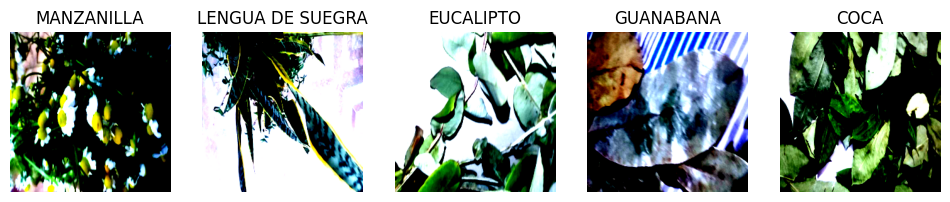

In [8]:
#Definir una función para mostrar imágenes
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1) 
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

#Inicializar un diccionario para almacenar una imagen por clase
class_images = {}

#Iterar sobre el DataLoader y guardar una imagen de cada clase
for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = train_dataset.dataset.classes[label]
        if class_name not in class_images:
            class_images[class_name] = img
        
        if len(class_images) == len(train_dataset.dataset.classes):
            break
    if len(class_images) == len(train_dataset.dataset.classes):
        break

#Graficar una imagen de cada clase
plt.figure(figsize=(12, 8))
for idx, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(1, len(class_images), idx + 1)
    imshow(img, title=class_name)

plt.show()

## **Filtros (Kernel) 1 imagen**

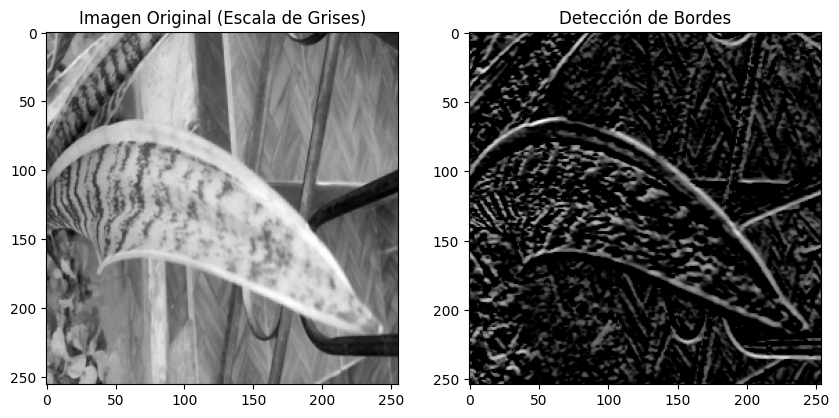

In [9]:
#Seleccionar un índice aleatorio
ix = random.randint(0, len(train_dataset) - 1)

#Obtener la imagen y la etiqueta correspondientes
img, label = train_dataset[ix]

#Convertir la imagen de tensor a numpy array
img = img.permute(1, 2, 0).numpy()

#Deshacer la normalización
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img = std * img + mean  
img = np.clip(img, 0, 1)

#Convertir la imagen a escala de grises
img_gray = color.rgb2gray(img)

#Definir el kernel para la detección de bordes
kernel = np.array([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])

#Aplicar la convolución con el kernel
edges = scipy.signal.convolve2d(img_gray, kernel, mode='valid')

#Aplicar la ecualización adaptativa al histograma
edges = exposure.equalize_adapthist(edges / np.max(np.abs(edges)), clip_limit=0.03)

#Mostrar la imagen original y la imagen con detección de bordes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_gray, cmap=plt.cm.gray)
ax1.set_title('Imagen Original (Escala de Grises)')
ax2.imshow(edges, cmap=plt.cm.gray)
ax2.set_title('Detección de Bordes')
plt.show()


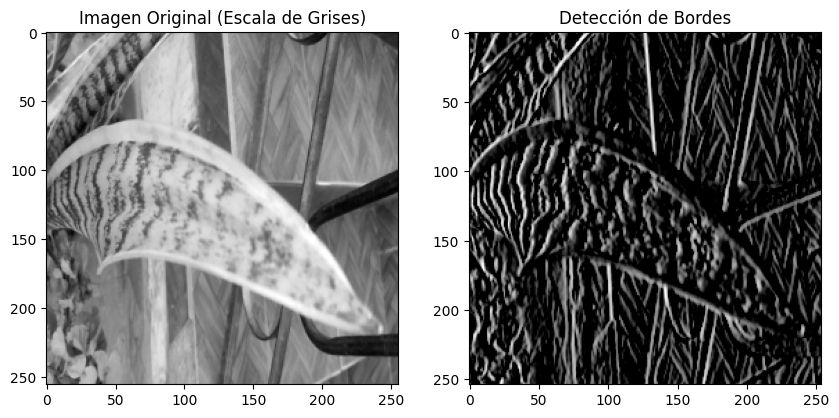

In [10]:
#Definir el kernel para la detección de bordes
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

#Aplicar la convolución con el kernel
edges = scipy.signal.convolve2d(img_gray, kernel, mode='valid')

#Aplicar la ecualización adaptativa al histograma
edges = exposure.equalize_adapthist(edges / np.max(np.abs(edges)), clip_limit=0.03)

#Mostrar la imagen original y la imagen con detección de bordes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_gray, cmap=plt.cm.gray)
ax1.set_title('Imagen Original (Escala de Grises)')
ax2.imshow(edges, cmap=plt.cm.gray)
ax2.set_title('Detección de Bordes')
plt.show()


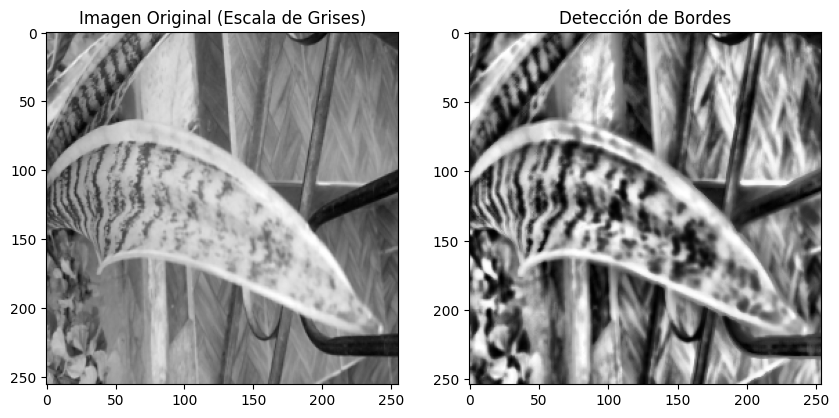

In [11]:
#Definir el kernel para la detección de bordes
kernel = np.array([[1, 0, 1],
                   [0, 1, 0],
                   [1, 0, 1]])

#Aplicar la convolución con el kernel
edges = scipy.signal.convolve2d(img_gray, kernel, mode='valid')

#Aplicar la ecualización adaptativa al histograma
edges = exposure.equalize_adapthist(edges / np.max(np.abs(edges)), clip_limit=0.03)

#Mostrar la imagen original y la imagen con detección de bordes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_gray, cmap=plt.cm.gray)
ax1.set_title('Imagen Original (Escala de Grises)')
ax2.imshow(edges, cmap=plt.cm.gray)
ax2.set_title('Detección de Bordes')
plt.show()


## **Aplicacion de una red convolucional en 2 plantas de ejemplo**

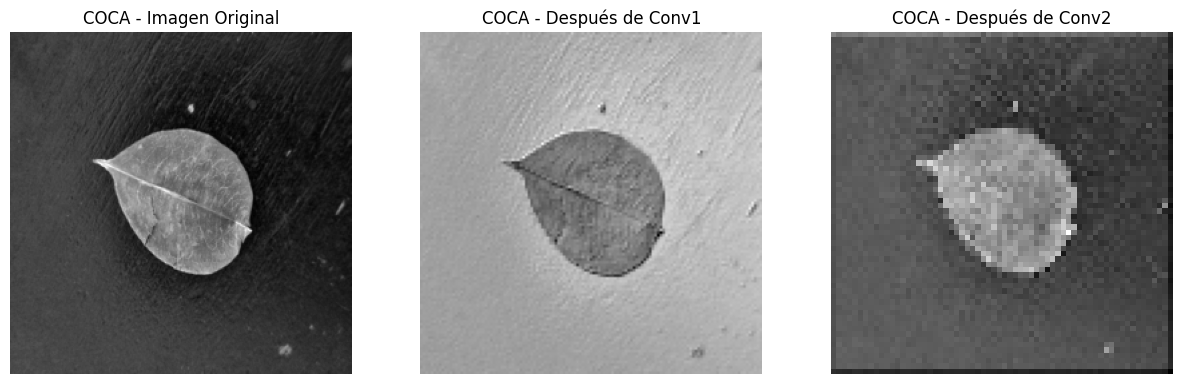

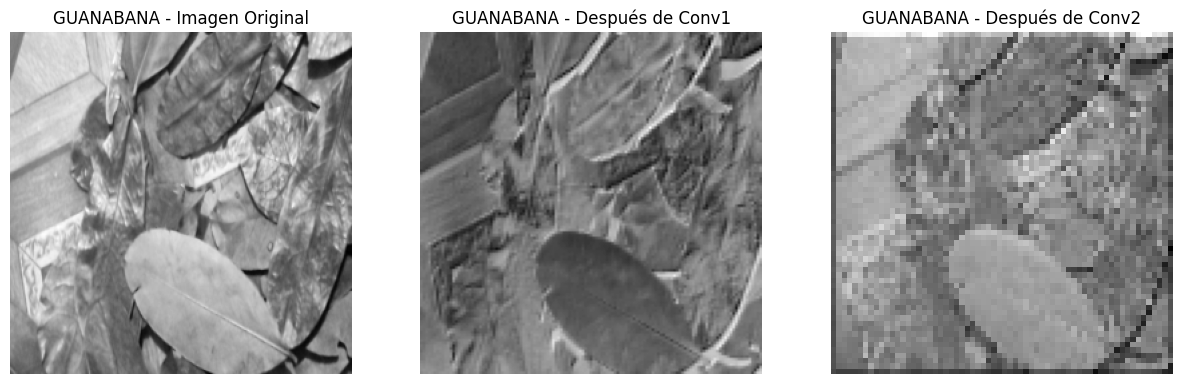

In [12]:
#Tranformaciones para las imagenes
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

#Rutas del dataset por clase
dataset_paths = {
    'COCA': "E:/LAB3SIS421/DATASETCONVOLUCIONAL/COCA",
    'GUANABANA': "E:/LAB3SIS421/DATASETCONVOLUCIONAL/GUANABANA",
}

#Función para mostrar las imágenes
def show_tensor_images(tensors, titles):
    fig, axes = plt.subplots(1, len(tensors), figsize=(15, 5))
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        img_np = tensor[0].detach().cpu().numpy()  # Seleccionar el primer canal
        axes[i].imshow(img_np, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

#Clase CNN simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=0, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=64, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        conv1_output = x.clone()
        
        x = self.conv2(x)
        conv2_output = x.clone()
        
        return conv1_output, conv2_output

#Crear el modelo
model = SimpleCNN()

#Iterar sobre cada clase del dataset
for class_name, class_path in dataset_paths.items():
    #Seleccionar una imagen aleatoria de la clase
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    
    #Cargar y transformar la imagen
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Añadir la dimensión de batch
    
    #Pasar la imagen por el modelo
    conv1_output, conv2_output = model(img_tensor)
    
    #Mostrar las imágenes 
    show_tensor_images(
        [img_tensor.squeeze(), conv1_output.squeeze(), conv2_output.squeeze()],
        [f"{class_name} - Imagen Original", f"{class_name} - Después de Conv1", f"{class_name} - Después de Conv2"]
    )


## **Capa de Pooling**

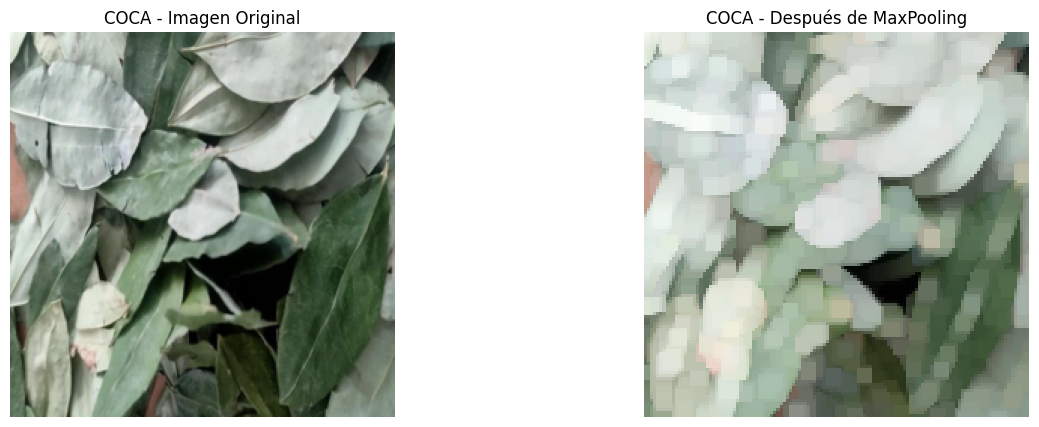

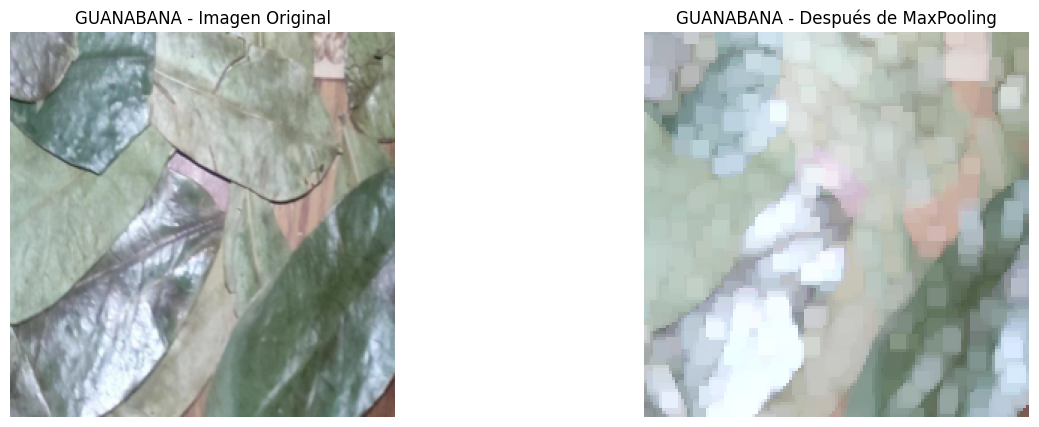

In [13]:
# Definir la capa de MaxPooling
pool = torch.nn.MaxPool2d(kernel_size=10, padding=1, stride=2)

#Función para mostrar las imágenes
def show_tensor_images(tensors, titles):
    fig, axes = plt.subplots(1, len(tensors), figsize=(15, 5))
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        img_np = tensor.permute(1, 2, 0).detach().cpu().numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

#Iterar sobre cada clase del dataset
for class_name, class_path in dataset_paths.items():
    #Seleccionar una imagen aleatoria de la clase
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    
    #Cargar y transformar la imagen
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Añadir la dimensión de batch
    
    #Aplicar MaxPooling a la imagen
    output = pool(img_tensor)
    
    #Mostrar las imágenes
    show_tensor_images(
        [img_tensor.squeeze(), output.squeeze()],
        [f"{class_name} - Imagen Original", f"{class_name} - Después de MaxPooling"]
    )


## **Entrenamiento**

**Carga de dataset**

In [14]:
#Definir el dispositivo, en mi caso se puede usar la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Transformaciones y carga del dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

#dataset_path = "E:/LAB3SIS421/DATASETCONVOLUCIONAL"
dataset_path = "E:/LAB3SIS421/DATASETPLANTAS"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

#Separar en entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Crear DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#Imprimir los tamaños del dataset, del entrenamiento y de la prueba
print(f"Tamaño total del dataset: {len(dataset)}")
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño total del dataset: 10000
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000


Se usara el dataset de 10k imagenes para la presentación debido al tiempo que requiere entrenar con el dataset de 75k imagenes

**Definimos las funciones para la red convolucional**

In [15]:
#Definir el bloque de la red convolucional
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        nn.ReLU(),
        nn.MaxPool2d(pk, stride=ps)
    )

#Definir el modelo CNN
class CNN(nn.Module):
    def __init__(self, n_channels=3, n_outputs=5):  #3 canales de entrada para RGB y 5 clases
        super(CNN, self).__init__()
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.conv3 = block(128, 256)
        self.fc1 = nn.Linear(256 * 32 * 32, 512)  #Adaptar tamaño a la salida del último bloque convolucional
        self.fc2 = nn.Linear(512, n_outputs)      #Capa de salida con 5 clases

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  #Aplanar las dimensiones
        x = self.fc1(x)
        x = self.fc2(x)
        return x

#Inicializar el modelo y moverlo a GPU
model = CNN().to(device)

**Entrenamiento de la red convolucional**

In [16]:
#Configurar el entrenamiento
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#Historial de entrenamiento
hist = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

#Entrenamiento
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Mover imagagenes a la GPU 

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    #Evaluación en el conjunto de prueba
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data)

    val_loss = val_running_loss / len(test_loader)
    val_acc = val_running_corrects.double() / len(test_loader.dataset)

    #Guardar estadísticas en el historial
    hist['epoch'].append(epoch + 1)
    hist['loss'].append(epoch_loss)
    hist['acc'].append(epoch_acc.item())
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc.item())

    #Imprimir resultados
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

100%|██████████| 125/125 [07:50<00:00,  3.76s/it]


Epoch [1/5] Loss: 1.1107 Acc: 0.7037 Val Loss: 0.3161 Val Acc: 0.8935


100%|██████████| 125/125 [08:13<00:00,  3.95s/it]


Epoch [2/5] Loss: 0.2971 Acc: 0.9018 Val Loss: 0.2290 Val Acc: 0.9290


100%|██████████| 125/125 [08:18<00:00,  3.99s/it]


Epoch [3/5] Loss: 0.1807 Acc: 0.9416 Val Loss: 0.1766 Val Acc: 0.9405


100%|██████████| 125/125 [06:32<00:00,  3.14s/it]


Epoch [4/5] Loss: 0.1062 Acc: 0.9621 Val Loss: 0.1561 Val Acc: 0.9535


100%|██████████| 125/125 [06:10<00:00,  2.97s/it]


Epoch [5/5] Loss: 0.0596 Acc: 0.9790 Val Loss: 0.1598 Val Acc: 0.9590


Con 5 epoch podemos ver que se logra una mayor precision que un MLP con 1000epochs aunque la red convolucional requiere mas recursos

In [17]:
#Evaluación del modelo entrenado
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #Mover los datos a la GPU
        images, labels = images.to(device), labels.to(device)
        
        #Obtener las predicciones del modelo
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        #Calcular la precisión
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Precisión del modelo en el conjunto de prueba: {accuracy:.2f}%')


Precisión del modelo en el conjunto de prueba: 95.90%


Se alcanzo una gran precisión solo con solo 5 epochs

Con esto podemos ver que una red convolucional aprende mas rapido y mejor que un MLP

## **Exportar modelo**

In [18]:
#Guardar el modelo en formato PyTorch (.pt)
torch.save(model.state_dict(), 'modelo_CNNLab3.pt')
# Definir un tensor de entrada de ejemplo (ajustado a las dimensiones de entrada de tu modelo)
dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Ajusta el tamaño según corresponda

#Exportar el modelo a ONNX
torch.onnx.export(model, dummy_input, 'modelo_CNNLab3.onnx', 
                  input_names=['input'], output_names=['output'],
                  export_params=True, opset_version=11)